<a href="https://colab.research.google.com/github/ZahraFarahzadii/GAN-CGAN/blob/main/ConditionalDCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import Libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import fashion_mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU, Dropout
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model
from keras import backend as K

In [ ]:
# load dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


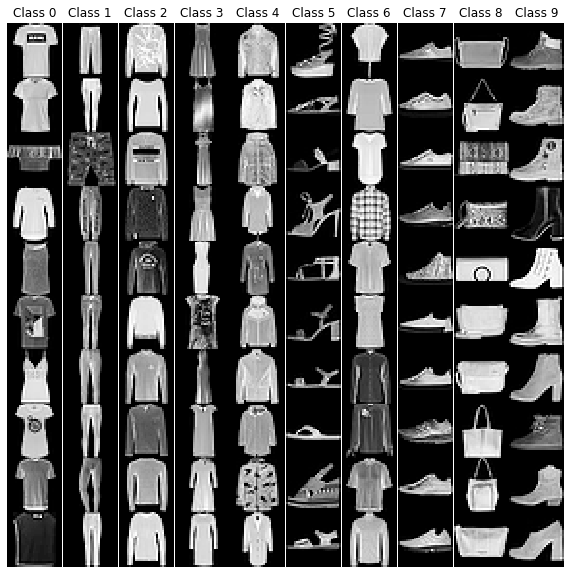

In [ ]:
#Display Data
fig = plt.figure()
fig.set_size_inches(10,10)
cnt=0
for i in range(10):
  for j in range(10):
    x_y = X_train[y_train == j]
    plt.subplot(10,10,cnt+1)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.imshow(x_y[cnt], cmap='gray', interpolation='none')
    if i==0: plt.title("Class %d" % (j))
    plt.axis('off')
    cnt=cnt+1
plt.show()

In [ ]:
# Reshaping and normalizing input images
print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# reshaping the inputs
X_train = X_train.reshape(60000, 28*28)
# normalizing the inputs (-1, 1)
X_train = (X_train.astype('float32') / 255 - 0.5) * 2

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 784)
y_train.shape (60000,)
X_train reshape: (60000, 784)


In [ ]:
# Define Generator model
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

generator.add(Dense(7*7*256, use_bias=False, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(BatchNormalization())
generator.add(LeakyReLU())

generator.add(Reshape((7, 7, 256)))
assert generator.output_shape == (None, 7, 7, 256) # Note: None is the batch size

generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
assert generator.output_shape == (None, 7, 7, 128)
generator.add(BatchNormalization())
generator.add(LeakyReLU())

generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
assert generator.output_shape == (None, 14, 14, 64)
generator.add(BatchNormalization())
generator.add(LeakyReLU())

generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
assert generator.output_shape == (None, 28, 28, 1)
# Output layer
generator.add(Flatten())

In [ ]:
# Generator model Summary
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)        

In [ ]:
# Conditional G model
# Embedding condition in input layer
num_classes = 10

# Create label embeddings
label = Input(shape=(1,), dtype='int32')
label_embedding = Embedding(num_classes, latent_dim)(label)
label_embedding = Flatten()(label_embedding)

# latent space
z = Input(shape=(latent_dim,))

# Merge inputs (z x label)
input_generator = multiply([z, label_embedding])

# Output image
img = generator(input_generator)

# Generator with condition input
generator = Model([z, label], img)

In [ ]:
# Conditional model summary
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1000        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 100)          0           embedding[0][0]                  
______________________________________________________________________________________________

In [ ]:
# Define Discriminator model

# Discriminator network
discriminator = Sequential()
discriminator.add(Reshape([28, 28, 1],input_shape=(img_dim,)))
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Flatten())
discriminator.add(Dense(1))


In [ ]:
# Discriminator model Summary
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)        

In [ ]:
# Embedding condition in input layer

# Create label embeddings
label_d = Input(shape=(1,), dtype='int32')
label_embedding_d = Embedding(num_classes, img_dim)(label_d)
label_embedding_d = Flatten()(label_embedding_d)

# imagem dimension 28x28
img_d = Input(shape=(img_dim,))

# Merge inputs (img x label)
input_discriminator = multiply([img_d, label_embedding_d])

# Output image
validity = discriminator(input_discriminator)

# Discriminator with condition input
discriminator = Model([img_d, label_d], validity)

In [ ]:
# model summary
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 784)       7840        input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 784)          0           embedding_1[0][0]                
____________________________________________________________________________________________

In [ ]:
# Define Discriminator Optimizer and Compile
optimizer = Adam(lr=1e-4, beta_1=0.5)

discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [ ]:
# Combine and Connect Network
discriminator.trainable = False

validity = discriminator([generator([z, label]), label])

d_g = Model([z, label], validity)

d_g.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [ ]:
# GAN model summary
d_g.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 784)          2331944     input_2[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 1)            220705      model[0][0]                

In [ ]:
# Train
# Fitting the model
epochs = 100
batch_size = 64
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):

        # Train Discriminator weights
        discriminator.trainable = True

        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1)

        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels], y=real * (1 - smooth))

        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        X_fake = generator.predict_on_batch([z, random_labels])

        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)

        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

        # Train Generator weights
        discriminator.trainable = False

        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )

    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 100
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = np.arange(0, 10).reshape(-1, 1)
        labels2=np.repeat(labels,10,axis=1).T
        labels2=labels2.reshape(100,1)
        x_fake = generator.predict([z, labels2])

        #Display Data
        fig = plt.figure()
        fig.set_size_inches(10,10)
        cnt=0
        for k in range(10):
            for l in range(10):
              plt.subplot(10,10,cnt+1)
              plt.subplots_adjust(wspace=0, hspace=0)
              plt.imshow(x_fake[cnt].reshape(28, 28), cmap='gray')
              # if i==0: plt.title("Class %d" % (j))
              plt.axis('off')
              cnt=cnt+1
        plt.show()

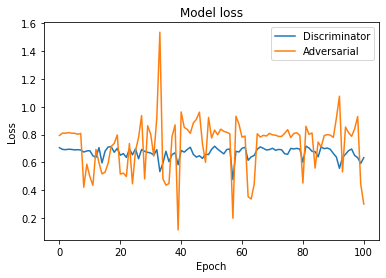

In [ ]:
# plotting the Loss functions
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='upper right')
plt.show()

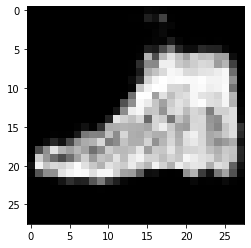

In [ ]:
#Generating New images
samples = 10
z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
labels = np.arange(0, 10).reshape(-1, 1)
my_x_fake = generator.predict([z, labels])
plt.imshow(my_x_fake[9].reshape(28, 28), cmap='gray')
